# Figure 4a

Correlations stuff

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
from parameters import params
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Parameters

In [3]:
quench_time = 300*ureg.s
evolution_time = 60*ureg.s
total_time = quench_time + evolution_time
sim_path = '../data/sims/'

## Correlations

Here I will generalte all the correlation timeseries for all realizations for all particles.

In [4]:
data = pd.read_csv(os.path.join(sim_path,'rparallels.csv'), index_col=[0,1])
data

0         1         2         3         4         5  \
realization frame                                                              
1           0     -1.50000 -1.500000  1.500000  1.500000  1.500000  1.500000   
            5     -1.36340 -1.468699  1.409801  1.371201  1.477997  0.806602   
            10    -1.49675 -0.899199  1.405701  1.337200  1.443298  1.019600   
            15    -1.43174 -1.103700  1.345100  1.271799  1.490898  1.191002   
            20    -1.47243 -1.134600  1.214100  1.487400  1.141399  0.748203   
...                    ...       ...       ...       ...       ...       ...   
10          7175   0.23227  1.303300 -0.829899 -0.819401  1.064499 -0.549797   
            7180   0.02659  1.288200 -0.777199 -0.813400  1.077297 -0.395100   
            7185   0.17713  1.165800 -0.785000 -0.925400  0.990898  0.011402   
            7190   0.00055  1.273300 -0.664499 -0.792101  0.825600 -0.233997   
            7195   0.27571  1.283700 -0.672899 -0.892500  1.163300 -0.713799   

                          6         7         8         9  ...      1790  \
realization frame                                          ...             
1           0     -1.500000  1.500000  1.500000 -1.500000  ... -1.500000   
            5     -0.957699  1.353600  1.453598 -1.322998  ... -1.353012   
            10    -0.707699  1.410202  1.502502 -1.371498  ... -1.102005   
            15    -0.090199  1.121201  1.405998 -1.495102  ... -1.084000   
            20    -0.195499  0.820099  1.431900 -1.428200  ... -1.289001   
...                     ...       ...       ...       ...  ...       ...   
10          7175  -0.598000 -0.995800  1.499497 -1.503601  ... -1.522003   
            7180  -0.895199 -1.066700  1.513802 -1.515701  ... -1.525009   
            7185  -0.808800 -1.098400  1.499199 -1.513100  ... -1.522003   
            7190  -0.803200 -1.088299  1.490799 -1.498802  ... -1.531998   
            7195  -0.904499 -0.936600  1.500198 -1.514298  ... -1.525009   

                       1791      1792      1793      1794      1795      1796  \
realization frame                                                               
1           0     -1.500000  1.500000 -1.500000 -1.500000 -1.500000  1.500000   
            5     -1.289001  1.235001 -1.354004 -1.458008 -1.264999  1.136002   
            10    -1.473007  0.710999 -1.335007 -1.434998 -1.483002  1.384995   
            15    -1.322006  1.054001 -1.362000 -1.437012 -1.334000  1.498001   
            20    -1.439011  0.824997 -1.427002 -1.375000 -1.249008  1.097000   
...                     ...       ...       ...       ...       ...       ...   
10          7175  -1.507004 -1.526001 -1.505005  1.524002 -1.529999 -1.511002   
            7180  -1.500000 -1.518997 -1.508011  1.537994 -1.531006 -1.518005   
            7185  -1.501007 -1.516998 -1.518997  1.534988 -1.521011 -1.511002   
            7190  -1.516007 -1.511002 -1.528000  1.520996 -1.526001 -1.505005   
            7195  -1.500000 -1.526001 -1.522003  1.528992 -1.541000 -1.514999   

                       1797      1798      1799  
realization frame                                
1           0      1.500000 -1.500000 -1.500000  
            5      1.266998 -1.285004 -1.156006  
            10     1.405991 -1.339005 -0.934998  
            15     1.345001 -1.324005 -0.977005  
            20     0.944000 -1.488007 -0.886002  
...                     ...       ...       ...  
10          7175  -1.551010  1.514999 -1.531006  
            7180  -1.544006  1.516998 -1.518997  
            7185  -1.549011  1.511002 -1.513000  
            7190  -1.533005  1.526001 -1.525009  
            7195  -1.538010  1.520996 -1.513000  

[15600 rows x 1800 columns]

In [5]:
realizations = data.index.get_level_values('realization').unique().to_list()

h = 20
intervals = [(0, 20),
 (20, 40),
 (40, 60),
 (60, 80),
 (80, 100),
 #(100, 120),
 #(120, 140),
 #(140, 160),
 (160, 180),
 #(180, 200),
 #(200, 220),
 (220, 240),
 #(240, 260),
 #(260, 280),
 (280, 300)]


In [6]:
def correlate_realization(sim_path,data,realization,interval,s,e):
    """
        This calculates the correlations functions for all particles in a given time interval.
        Saves all the data.
    """
    
    # Selecting the appropiate realization and its frames
    cdata = data.loc[idx[realization,:]]
    sframes = cdata.index.get_level_values('frame').unique().to_list()
    particle_ids = data.columns
    
    # Selecting all the particles time-selies
    cts = cdata[particle_ids].to_numpy().transpose()
    subselframes, correlations = aux.correlate_bframes(params,cts,sframes,stime=s,etime=e)

    # Making the appropiate df
    corr_df = pd.DataFrame(np.array(correlations).transpose()) # Putting each time-series as columns
    numbered = list(corr_df.columns)
    corr_df['frame'] = subselframes
    corr_df['realization'] = [realization] * len(subselframes)
    corr_df[['realization','frame'] + numbered]

    if realization == 1:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False)
    else:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False, header=False, mode='a')
    


In [ ]:
corr_path = '../data/figs/correlations'
for i,(s,e) in enumerate(intervals):
    for realization in realizations:
        
        correlate_realization(corr_path,data,realization,i,s,e)

## Averages

Now it is time to load them one by one and take the averages, std, normalize and stuff.

In [10]:
for interval in range(8):
    avs = []
    for realization in realizations:
        corr_int = pd.read_csv(os.path.join(corr_path,f'corr{interval}.csv'),index_col=['realization','frame'])
        frames = corr_int.index.get_level_values('frame').unique().to_numpy()
        dt = (frames - frames[0]) / params['framespersec'].magnitude
        
        particle_average = corr_int.loc[idx[realization,:]].mean(axis=1)
        particle_average = particle_average / particle_average.max()
        avs.append(particle_average.to_list())

    df = pd.DataFrame( np.array(avs).mean(axis=0), columns=['av'])
    df['dt'] = dt
    df['interval'] = [interval] * len(frames)

    if interval == 0:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False)
    else:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False,mode = 'a', header=False)



## Visualization

In [8]:
corravs = pd.read_csv(os.path.join(corr_path,'global.csv'), index_col=['interval','dt'])
nintervals = corravs.index.get_level_values('interval').unique().to_list()

In [9]:
rate = params['max_field']/quench_time
fields = [np.round((i[0]+i[1])/2 * rate.magnitude, decimals=2) for i in intervals]
fields


[0.33, 1.0, 1.67, 2.33, 3.0, 5.67, 7.67, 9.67]

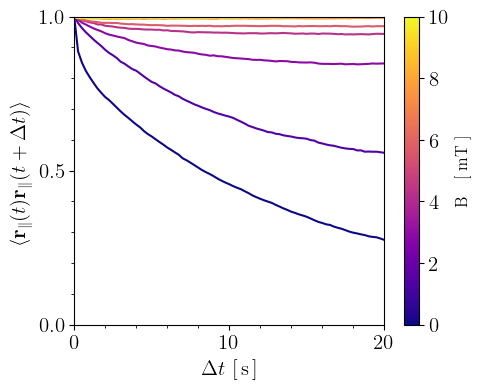

In [13]:
fig, ax = plt.subplots(figsize = (5,4))
cmap = plt.get_cmap('plasma')

for interval, (i,B) in zip(nintervals, enumerate(fields)):
    color =  cmap(i / (len(fields) - 1))
    avi = corravs.loc[idx[interval,'av']]
    ax.plot(avi.index.to_list(),avi.to_list(), color=color)

ax.set_xlim(0,h)
ax.set_ylim(0,1)
ax.set_xlabel("$\\Delta t$ [\,s\,]", fontsize=15)
ax.set_ylabel("$\\langle \mathbf{r}_\parallel(t) \mathbf{r}_\parallel(t+\\Delta t)\\rangle$",fontsize=15)

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

ax.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=10))
sm.set_array([])
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label(label='B \,\, [ mT ]',size='large')
cbar.ax.tick_params(labelsize=15)


fig.savefig(os.path.join('../data/figs','fig4a.png'),dpi=300,bbox_inches='tight')
fig.savefig(os.path.join('../data/figs','fig4a.pdf'))

plt.show()

## Energy as a function of time

In [ ]:
def calulate_energy_at_frame_rl(params,data_path,size,frame,realization):
    
    params['size'] = size
    
    trj = pd.read_csv(os.path.join(data_path,str(size),'trj',f'trj{realization}.csv'), index_col=[0,1])
    #last_frame = trj.index.get_level_values('frame').unique()[-1]
    particles = aux.get_coordinates_at_frame(trj,frame)
    dis_energy = aux.calculate_energy(params,particles)
    return dis_energy